#<font color= "green"> Project Explanation </font>

The following project focuses on analyzing the data contained in the DataFrame below, which includes statistics related to aircraft incidents that occurred between 1919 and 2023. Specifically, the fields indicated are: the date (day-month-year) of the incident, the type of aircraft involved in the disaster, its registration number, the airline, the number of fatalities, the location of the incident, the country where it occurred, and the year it took place.

Based on this information, I proceeded with the following analyses: </br>

* Analysis of the number of incidents in each country; </br>

* Analysis of the temporal trend of fatalities: </br>
** Number of fatalities by day of the week; </br>
** Number of fatalities by month; </br>
** Number of fatalities by year; </br>
** Focus on the trend of incidents after 2001. </br>

* Analysis of the number of fatalities by aircraft type; </br>

* Analysis of fatalities by airline; </br>

* Analysis of fatalities by location of the incident. </br>

At the beginning of each section, the relevant dataset columns are cleaned according to the subject under analysis, followed by grouping the data based on the element of focus. Finally, a chart is created to visually represent the grouped data. </br>

The original DataFrame was never directly modified; instead, all operations were performed on copies of it. This approach ensures that we always have the correct reference in case any issues arise during the analysis.

In [ ]:
#import the libraries useful for the analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import string

In [ ]:
#read the csv file and pass it to a pandas DataFrame

df= pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/aviation-accidents.csv")

df_copy= df.copy()

df_copy.head()

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


In [ ]:
#check how many values are Nan

df_copy.isna().sum()

,0
date,0
type,0
registration,1548
operator,4
fatalities,3938
location,948
country,0
cat,0
year,0


In [ ]:
#here's a function that attempts to convert as many values as possible to the correct encoding
#if the attempt fails, it simply returns the original entry

def check_string(s):

  try:

    return s.encode("Latin-1").decode("utf-8")

  except Exception:

    return s

# <font color="red"> Most Fatalities country </font>

In [ ]:
#obtain the coordinates that form the borders of the states, which are useful for implementing the cartogram depicting the distribution
#of accidents by country

boundaries= requests.get("https://r2.datahub.io/clvyjaryy0000la0cxieg4o8o/master/raw/data/countries.geojson").json()

#load the file into a Pandas DataFrame and select only the 'features' column, which contains all the data i need

bounded_df= pd.DataFrame(boundaries)

bounded_df= bounded_df.loc[:, "features"]

#convert the DataFrame into a dictionary

json_df= bounded_df.to_json()

countries_coord= json.loads(json_df)

In [ ]:
#add a check to verify that the states in the DataFrame match those in the GeoJSON file. This check is also useful for ensuring that
#the state names are spelled correctly.

def check_countries(a):

  for key, values in countries_coord.items():

    if values["properties"]["ADMIN"]==a:

      return(True)

In [ ]:
#the following function attempts to convert all values in the 'fatalities' column to integers. In cases where the conversion fails due to values that
#cannot be converted to integers, the function returns 'not a number'.

def check_fatalities(f):

  try:

    int_f= int(f)

    return int_f

  except ValueError:

    return "not a number"

In [ ]:
#check the values that were not converted and notice that the conversion failed due to the presence of the '+' operator in string format within the rows.
#therefore, develop an additional function to clean the 'fatalities' column thoroughly.

incorrect_fatalities=df.loc[df["fatalities"].apply(check_fatalities)=="not a number"]

In [ ]:
#this is the function mentioned above

def data_cleaner(t):

  if isinstance(t, str):

    if "+" in str(t):

      t_split=t.split("+")

      t_map=list(map(int, t_split))

      return sum(t_map)

    else:

      return int(t)

In [ ]:
#check the mean and the symmetry of the distribution

mean_fatalities=df_copy["fatalities"].apply(data_cleaner).mean(skipna=True)

skewness= df_copy["fatalities"].apply(data_cleaner).skew(skipna=True)

mean_fatalities, skewness

(6.62699086324829, 24.808065544642332)

In [ ]:
#apply the function to the column "fatalities"

df_copy["fatalities"]=df_copy["fatalities"].apply(data_cleaner)

In [ ]:
#apply the econding correction function to the country column

df_copy["country"]=df_copy["country"].apply(check_string)

In [ ]:
#group the DataFrame by country and display the total number of fatalities for each

grouped_df_country=df_copy.groupby("country")["fatalities"].sum().reset_index()

In [ ]:
#identify the problematic states and notice that many of them are an issue because they are not written correctly. Therefore, to achieve the most
#accurate possible graph, in the next cell I will manually correct the errors, as they are not too numerous.

nan_index=grouped_df_country.loc[grouped_df_country["country"].apply(check_countries).isna()]

In [ ]:
#this is the correction mentioned above

countries= {"Caribbean Neth'lands":"Caribbean Netherlands", "USA":"United States of America",
            "C.A.R.":"Central African Republic", "U.K.":"United Kingdom", "U.A.E.":"United Arab Emirates", "D.R. Congo":"Democratic Republic of the Congo",
            "P.N. Guinea":"Papua New Guinea", "Serbia":"Republic of Serbia", "Bosnia":"Bosnia and Herzegovina", "Antigua":"Antigua and Barbuda",
            "Sao Tome":"Sao Tome and Principe", "Timor":"East Timor", "Congo":"Republic of Congo", "Northern Mariana Isl":"Northern Mariana Islands",
            "U.S. M.O. Islands":"United States Minor Outlying Islands", "Cote d'Ivoire":"Ivory Coast", "Bahamas":"The Bahamas", "U.S. Virgin Isl.":"United States Virgin Islands",
            "Turks & Caicos":"Turks and Caicos Islands", "Tanzania":"United Republic of Tanzania", "Micronesia":"Federated States of Micronesia",
            "Hong Kong":"Hong Kong S.A.R.", "St. Helena":"Saint Helena", "Cayman Isl.":"Cayman Islands", "Christmas Isl.":"Christmas Islands",
            "Cocos Isl.":"Cocos Islands", "Cook Isl.":"Cook Islands", "Falkland Isl.":"Falkland Islands", "Marshall Isl.":"Marshall Islands",
            "Solomon Isl.":"Solomon Islands", "St. Kitts & Nevis":"St. Kitts and Nevis", "St.Pierre & Miquelon":"St. Pierre and Miquelon",
            "Trinidad & Tobago": "Trinidad and Tobago"}

def change_names(y):

  if y not in countries.keys():

    yield y

  else:

    for state, correct_state in countries.items():

      if y == state:

        yield (y.replace(y, correct_state))

      else:

        continue


In [ ]:
def conv(d):

  for i in d:

    return i

In [ ]:
#apply the function to the column "country"

grouped_df_country["country"]=grouped_df_country["country"].apply(change_names)

In [ ]:
grouped_df_country["country"]=grouped_df_country["country"].apply(conv)

In [ ]:
#following the application of the function, it can be observed that the most significant figures, in relation to the number of fatalities,
#remain in the oceans. However, the details can still be viewed in the bar chart just below.

after_check=grouped_df_country.loc[grouped_df_country["country"].apply(check_countries).isna()]

In [ ]:
#create a world map displaying the distribution of fatalities for each country
#NaN countries are colored blue to easily identify them

world_map=folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(geo_data=boundaries,
                     data= grouped_df_country,
                     columns=["country", "fatalities"],
                     key_on= "properties.ADMIN",
                     fill_color= "YlOrRd",
                     bins=np.arange(0, 21000, 1000),
                     nan_fill_color="white",
                     line_weight= 0.8,
                     line_opacity=0.5,
                     legend_name= "Fatalities in each country",
                     smooth_factor= 1.5,
                     highlight= True).add_to(world_map)

world_map

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#highlight the country with the highest number of fatalities

max_fatalities=grouped_df_country.loc[grouped_df_country["fatalities"]==grouped_df_country["fatalities"].max()]

max_fatalities

,country,fatalities
219,United States of America,19305.0


In [ ]:
#define a function which show fatalities information about the country passed as argument

def country_info(i):

  return grouped_df_country.loc[grouped_df_country["country"]==i]

# <font color="red">Days of the week with the most fatalities </font>

In [ ]:
#convert the dates from strings to Datetime objects

df_copy["date"]=pd.to_datetime(df_copy["date"], errors= "coerce", dayfirst=True, format= "mixed")

In [ ]:
#After converting to dates, I identify the indices of dates that do not have an exact date format and check how many fatalities occurred on those dates.
#Out of a total of 498 rows, there are 41 fatalities. In the analysis of the number of incidents occurring per day of the week, these dates cannot be
#included in the count because the day is unknown; only the month and year, or sometimes just the year, are known.
#Therefore, they will be considered later when the analysis is performed on fatalities per year. Additionally, with only 41 fatalities, the result of the
#analysis will not be significantly affected.

not_corrects_dates=df_copy.loc[df_copy["date"].isna()].index

partially_df_copy=df_copy.loc[not_corrects_dates, ["date", "fatalities"]].reset_index()

partially_df_copy["fatalities"].sum()

41.0

In [ ]:
#group the DataFrame by date and display the number of fatalities that occurred on each day

grouped_df_date= df_copy.groupby("date")["fatalities"].sum().reset_index()

In [ ]:
#add a new column to the DataFrame containing the day of the week corresponding to each date

grouped_df_date["day"]=grouped_df_date["date"].dt.day_name()

In [ ]:
#define a time period in which to display the dates

grouped_df_date["date"]=grouped_df_date["date"].dt.to_period("d")

In [ ]:
#crate a sub-DataFrame which contain the day from 2001

grouped_df_date_2001=grouped_df_date.loc[grouped_df_date["date"].dt.year>=2001]

In [ ]:
#convert the dates to strings so that they can be represented on the graph

grouped_df_date["date"]=grouped_df_date["date"].apply(lambda x: str(x))

grouped_df_date_2001["date"]=grouped_df_date_2001["date"].apply(lambda x: str(x))

<ipython-input-29-ee0e5c8ffb75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_date_2001["date"]=grouped_df_date_2001["date"].apply(lambda x: str(x))


In [ ]:
#sort the date

grouped_df_date=grouped_df_date.sort_values("date")

grouped_df_date_2001=grouped_df_date_2001.sort_values("date")

In [ ]:
#group the DataFrame by days of the week, highlighting the total number of deaths that occurred on those days

max_days_fatalities= grouped_df_date.groupby("day")["fatalities"].sum()

max_days_fatalities_2001=grouped_df_date_2001.groupby("day")["fatalities"].sum()

In [ ]:
#sort the day columns by the week's days order

days=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

max_days_fatalities= max_days_fatalities.reindex(days, axis=0).reset_index()

max_days_fatalities_2001=max_days_fatalities_2001.reindex(days, axis=0).reset_index()

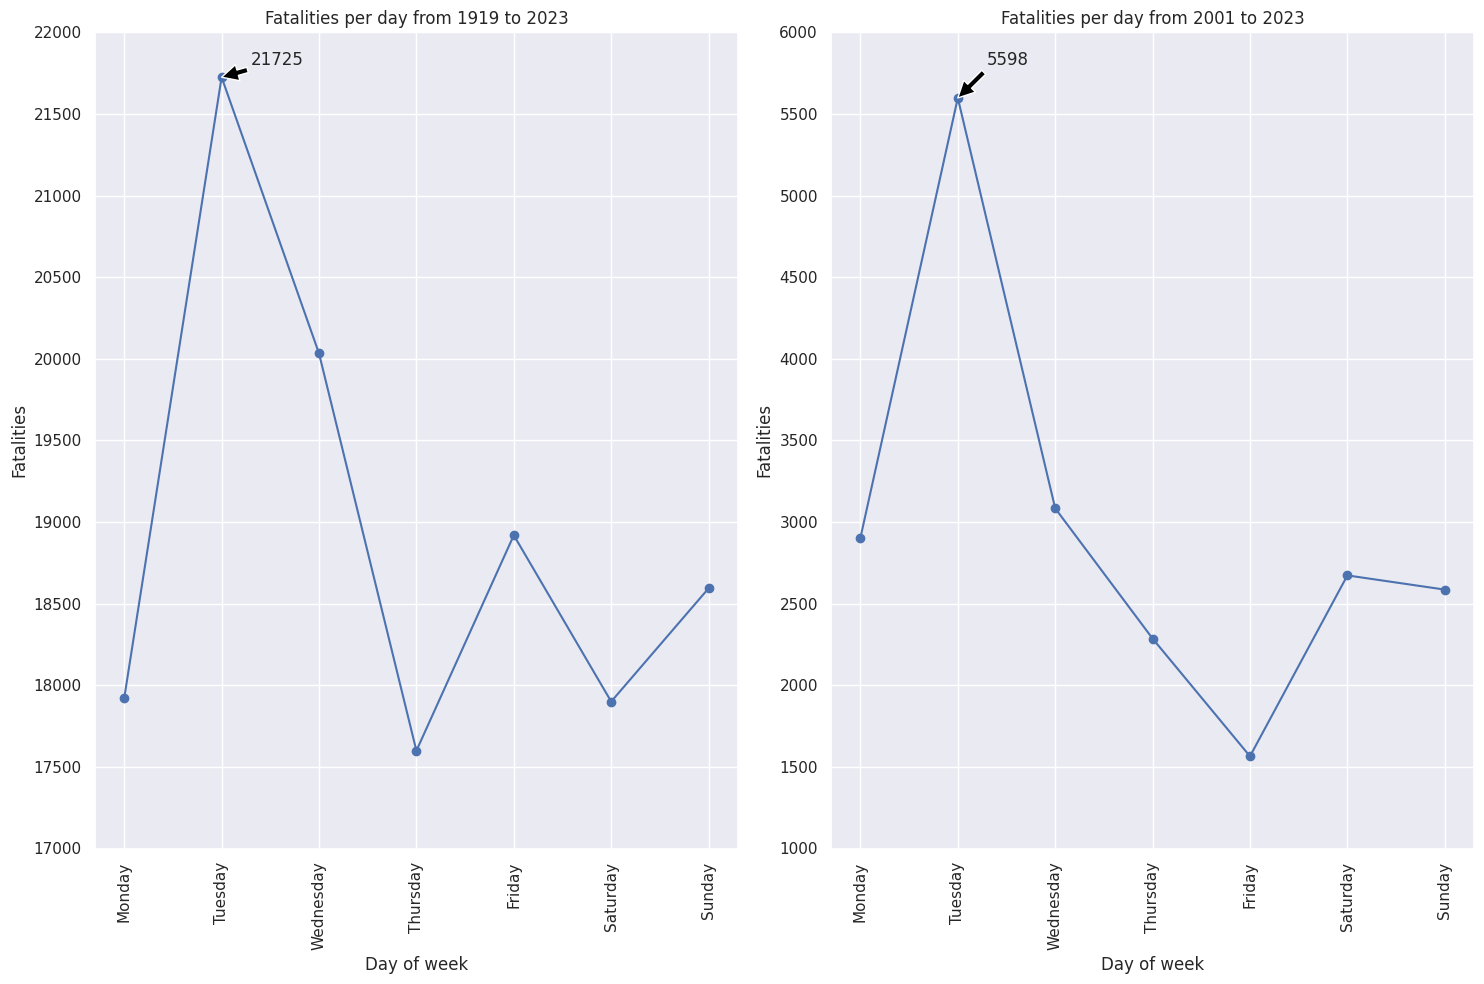

In [76]:
#make a line chart showing the total number of fatalities for each day of the week


fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(15, 10))

plt.rcdefaults()

plt.rcParams["font.size"]=8

sns.set_theme()


ax1.set_title("Fatalities per day from 1919 to 2023")

ax1.plot(max_days_fatalities["day"], max_days_fatalities["fatalities"], marker="o", label= "Days from 1919 to 2023")

ax1.set_xlabel("Day of week")

ax1.set_ylabel("Fatalities")

ax1.set_xticks(ticks=np.arange(0, 7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)

ax1.set_yticks(ticks=np.arange(17000, 22500, 500),

               labels=np.arange(17000, 22500, 500))

ax1.set_ylim(17000)

ax1.annotate("21725", xy=("Tuesday", 21725), xytext=(1.3, 21800), arrowprops=dict(facecolor="black"))



ax2.set_title("Fatalities per day from 2001 to 2023")

ax2.plot(max_days_fatalities_2001["day"], max_days_fatalities_2001["fatalities"], marker="o", label= "Days from 2001 to 2023")

ax2.set_xlabel("Day of week")

ax2.set_ylabel("Fatalities")

ax2.set_xticks(ticks=np.arange(0, 7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=90)

ax2.set_yticks(ticks=np.arange(1000, 6500, 500),

              labels=np.arange(1000, 6500, 500))

ax2.annotate("5598", xy=("Tuesday", 5598), xytext=(1.3, 5800), arrowprops=dict(facecolor="black"))


plt.tight_layout()

plt.show()

plt.close()

We can observe from the two charts above that the trend in fatalities, when considering the entire time span compared to the focus from 2001 onward, generally follows the same pattern. However, an exception is seen on Friday, which in the first case shows a peak in fatalities compared to the previous day (Thursday). This rise does not occur in the second chart; in fact, the number of fatalities drops significantly from Thursday to Friday.

In [ ]:
#define a function which show fatalities information about the day passed as argument

def day_info(d):

  return max_days_fatalities.loc[max_days_fatalities["date"]==d]

In [ ]:
#define a function which show fatalities information about the day passed as argument from 2001 onward

def day_info_2001(x):

  return max_days_fatalities_2001.loc[max_days_fatalities_2001["date"]==x]

#<font color="red"> Number of fatalities per month </font>

In [ ]:
#create a copy of the copy of the original DataFrame so that I can work with dates in string format

df_copy_date=df.copy()

In [ ]:
#apply the data_cleaner function defined earlier to the "fatalities" column

df_copy_date["fatalities"]=df_copy_date["fatalities"].apply(data_cleaner)

In [ ]:
#define a function that splits each date into day, month, and year, then modifies only the day. This allows us to include dates that only have
#the month (but not the day) in the final count

def days_corrector(n):

  if str(n).split("-")[0]=="??":

    n_modified= str(n).split("-")[0].replace("??","01")+"-"+str(n).split("-")[1]+"-"+str(n).split("-")[2]

    return n_modified

  else:

    return n

In [ ]:
#apply the function to the date column

df_copy_date["date"]=df_copy_date["date"].apply(days_corrector)

In [ ]:
#convert the dates from strings to Datetime objects

df_copy_date["date"]=pd.to_datetime(df_copy_date["date"], errors= "coerce", dayfirst=True, format= "mixed")

In [ ]:
#create a sub-DataFrame with date and the number of fatalities for each, from 2001

df_copy_date_2001=df_copy_date.loc[df_copy_date["date"].dt.year>=2001]

In [ ]:
#group the DataFrame

grouped_df_month_2001= df_copy_date_2001.groupby(df_copy_date_2001["date"].dt.month_name())["fatalities"].sum()

In [ ]:
#group the DataFrame by date and the number of fatalities for each

grouped_df_month=df_copy_date.groupby(df_copy_date["date"].dt.month_name())["fatalities"].sum()

In [ ]:
#sort the DataFrame by months

months=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

grouped_df_month=grouped_df_month.reindex(months, axis=0).reset_index()

grouped_df_month_2001=grouped_df_month_2001.reindex(months, axis=0).reset_index()

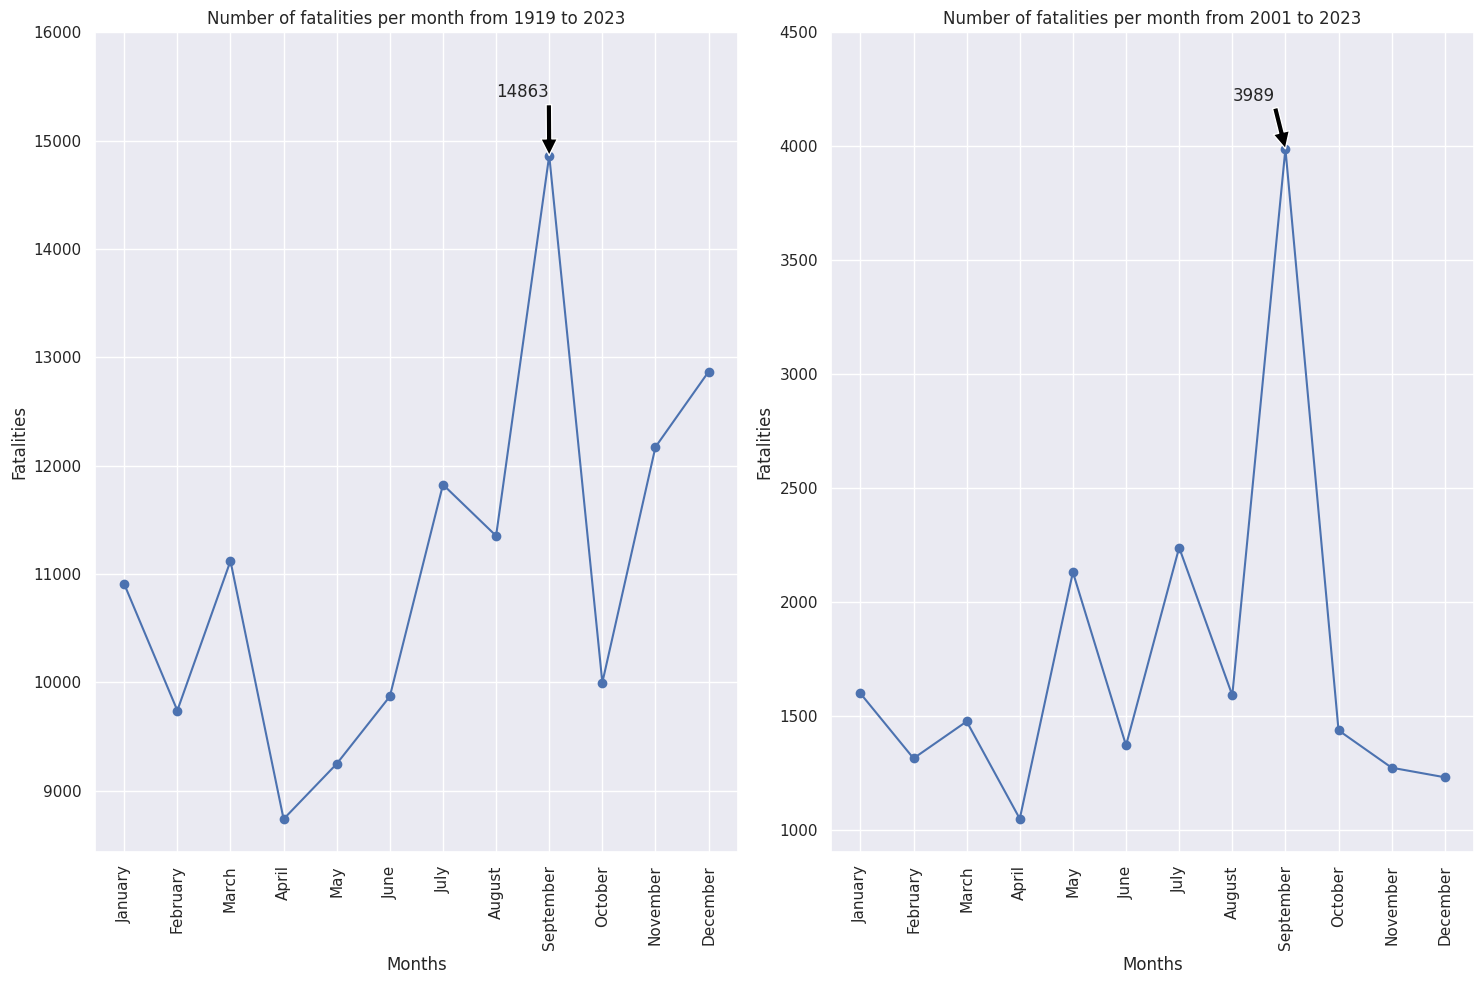

In [ ]:
#create a chart that shows how many fatalities occurred in each month of the year

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 10))

plt.rcdefaults()

plt.rcParams["font.size"]=10

sns.set_theme()


ax1.set_title("Number of fatalities per month from 1919 to 2023")

ax1.plot(grouped_df_month["date"], grouped_df_month["fatalities"], marker="o")

ax1.set_xlabel("Months")

ax1.set_ylabel("Fatalities")

ax1.set_xticks(ticks=np.arange(0, 12), labels=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],rotation=90)

ax1.set_yticks(ticks=np.arange(9000, 17000, 1000),
               labels=np.arange(9000, 17000, 1000))

ax1.annotate("14863", xy=("September", 14863), xytext=("August", 15400), arrowprops=dict(facecolor="black"))


ax2.set_title("Number of fatalities per month from 2001 to 2023")

ax2.plot(grouped_df_month_2001["date"], grouped_df_month_2001["fatalities"], marker="o")

ax2.set_xlabel("Months")

ax2.set_ylabel("Fatalities")

ax2.set_xticks(ticks=np.arange(0, 12), labels=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], rotation=90)

ax2.set_yticks(ticks=np.arange(1000, 5000, 500),
               labels=np.arange(1000, 5000, 500))

ax2.annotate("3989", xy=("September", 3989), xytext=("August", 4200), arrowprops=dict(facecolor="black"))



plt.tight_layout()

plt.show()

plt.close()

In the two charts above, a significant trend reversal can be observed from October onward. When focusing on the entire time span, it is evident that the number of fatalities increased considerably during the last two months of the year. In contrast, the chart focusing on the years from 2001 onward shows a downward trend in the final two months.

In [ ]:
#define a function which show fatalities information about the month passed as argument

def month_info(m):

  return grouped_df_month.loc[grouped_df_month["month"]==m]

In [ ]:
#define a function which show fatalities information about the month passed as argument from 2001 onward

def month_info_2001(b):

  return grouped_df_month_2001.loc[grouped_df_month_2001["month"]==b]

#<font color="red"> How have the fatalities evolved since September 11th? </font>

In [ ]:
#create a copy of the copy of the original DataFrame so that I can work with dates in string format.

df_copy_date=df.copy()

In [ ]:
#apply the data_cleaner function defined earlier to the "fatalities" column.

df_copy_date["fatalities"]=df_copy_date["fatalities"].apply(data_cleaner)

In [ ]:
#group the DataFrame based on years and fatalities occured in each of them

grouped_df_copy_date= df_copy_date.groupby("year")["fatalities"].sum().reset_index()

<ipython-input-51-d3cc6b54043b>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(grouped_df_copy_date["year"], rotation=90)
<ipython-input-51-d3cc6b54043b>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(grouped_df_copy_date["year"], rotation=90)
<ipython-input-51-d3cc6b54043b>:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(grouped_df_copy_date["year"], rotation=90)
<ipython-input-51-d3cc6b54043b>:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(grouped_df_copy_date["year"], rotation=90)


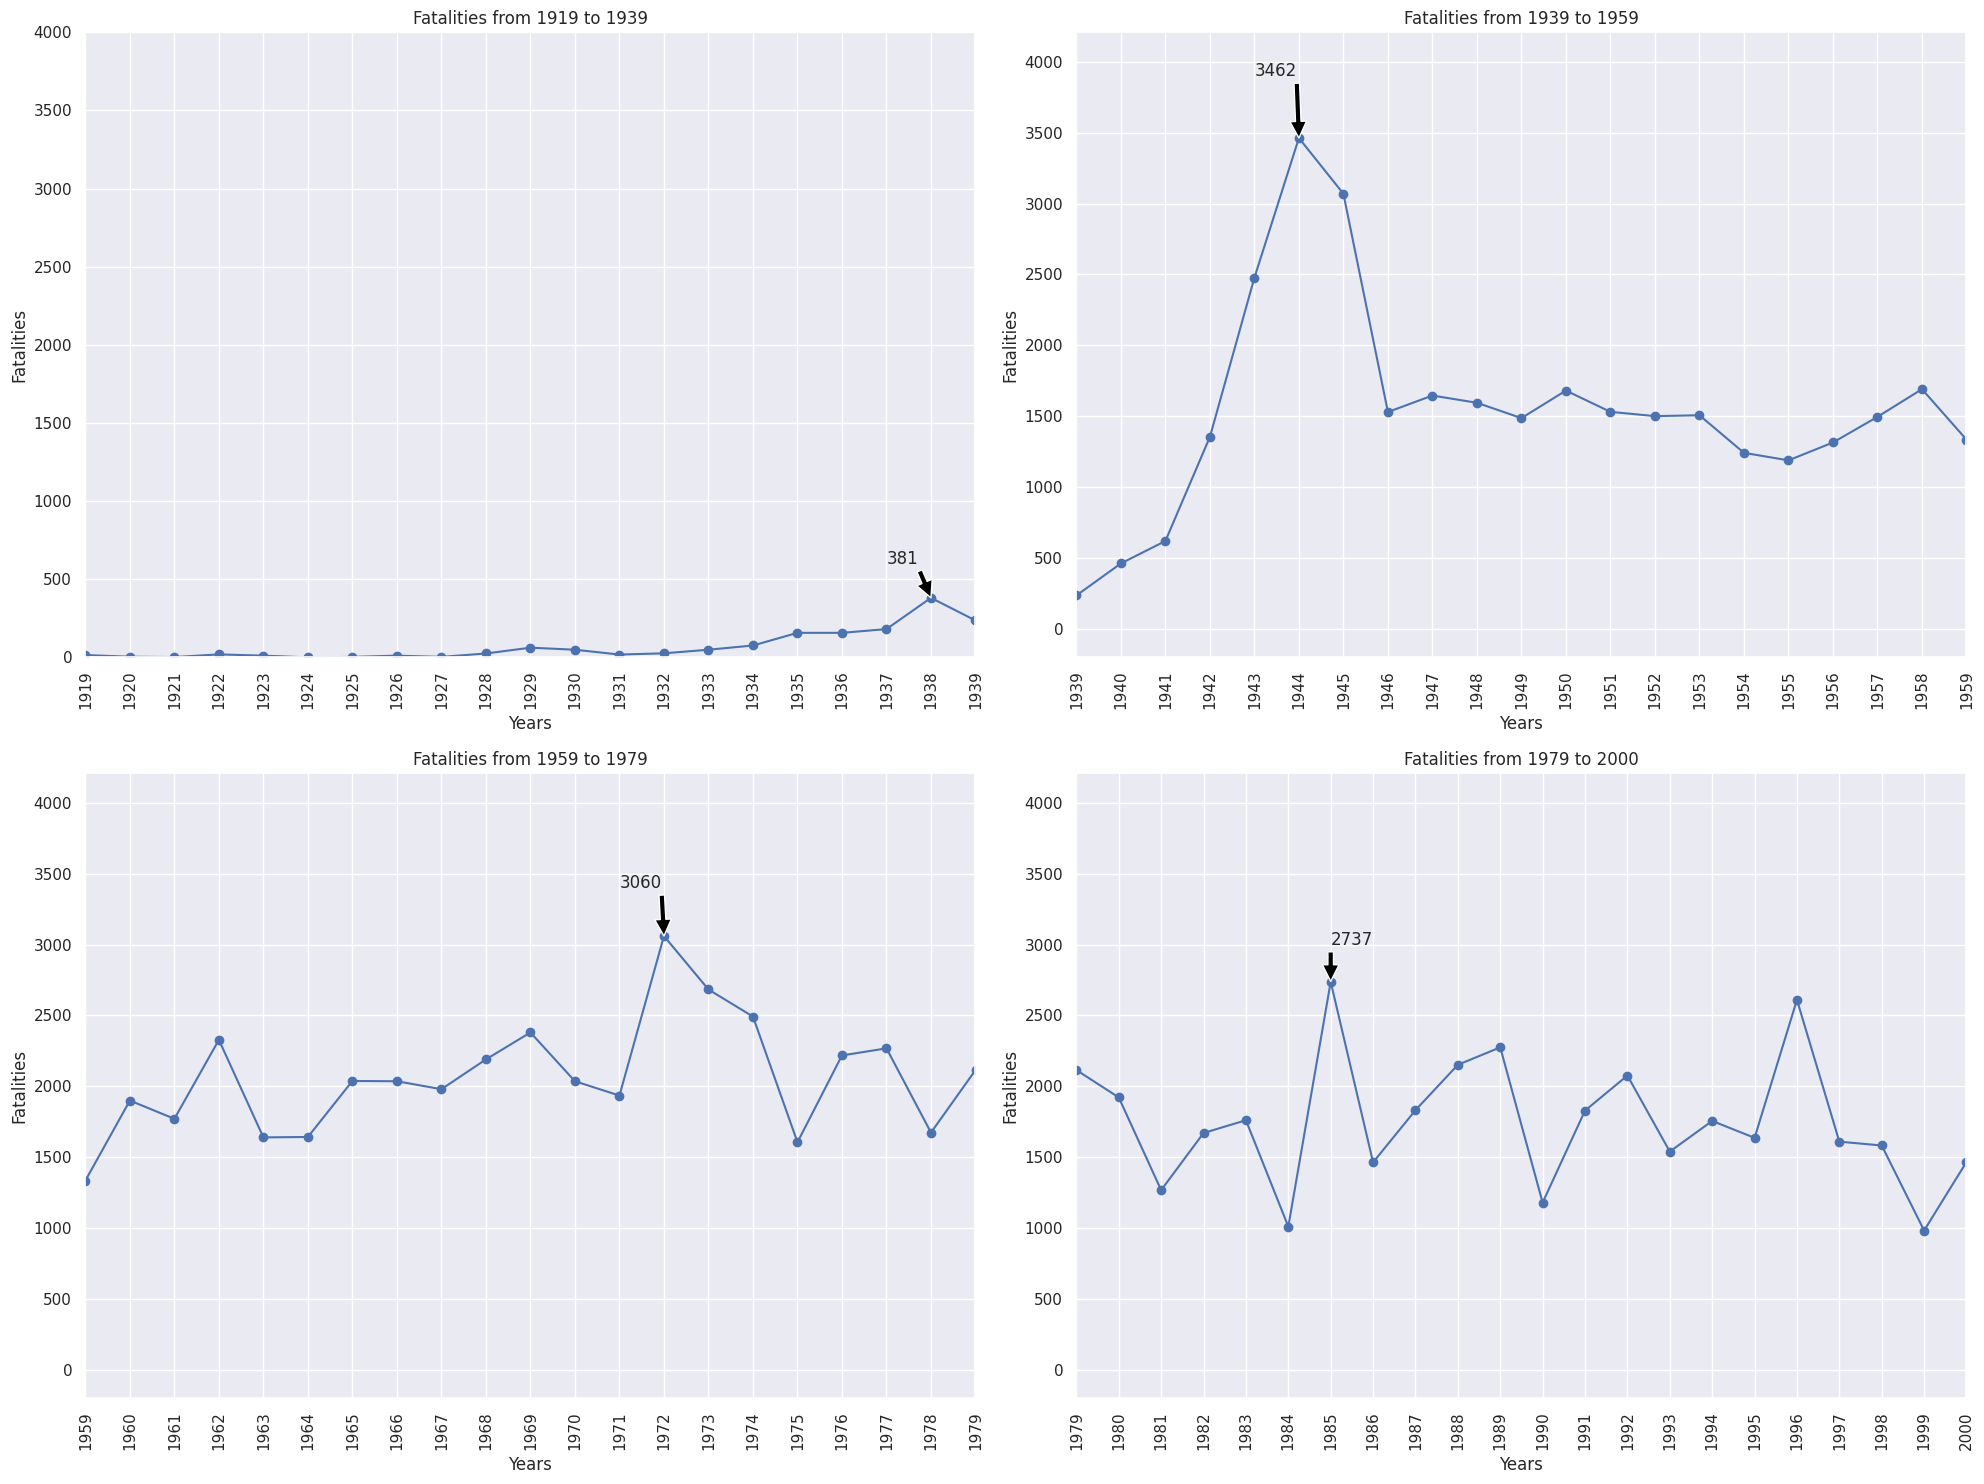

In [ ]:
#create a chart containing the data from the 4 sub-DataFrames.

fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize=(20, 15))

plt.rcdefaults()

plt.rcParams["font.size"]=10

sns.set_theme()


ax1.set_title("Fatalities from 1919 to 1939")

ax1.plot(grouped_df_copy_date["year"], grouped_df_copy_date["fatalities"], marker= "o")

ax1.set_xlabel("Years")

ax1.set_ylabel("Fatalities")

ax1.set_xticklabels(grouped_df_copy_date["year"], rotation=90)

ax1.set_xlim("1919", "1939")

ax1.set_ylim(0, 500)

ax1.set_yticks(np.arange(0, 4500, 500))

ax1.annotate("381", xy=("1938", 381), xytext=("1937", 600), arrowprops=dict(facecolor="black"))


ax2.set_title("Fatalities from 1939 to 1959")

ax2.plot(grouped_df_copy_date["year"], grouped_df_copy_date["fatalities"], marker= "o")

ax2.set_xlabel("Years")

ax2.set_ylabel("Fatalities")

ax2.set_xticklabels(grouped_df_copy_date["year"], rotation=90)

ax1.set_yticks(np.arange(0, 4500, 500))

ax2.set_xlim("1939", "1959")

ax2.annotate("3462", xy=("1944", 3462), xytext=("1943", 3900), arrowprops=dict(facecolor="black"))


ax3.set_title("Fatalities from 1959 to 1979")

ax3.plot(grouped_df_copy_date["year"], grouped_df_copy_date["fatalities"], marker= "o")

ax3.set_xlabel("Years")

ax3.set_ylabel("Fatalities")

ax3.set_xticklabels(grouped_df_copy_date["year"], rotation=90)

ax1.set_yticks(np.arange(0, 4500, 500))

ax3.set_xlim("1959", "1979")

ax3.annotate("3060", xy=("1972", 3060), xytext=("1971", 3400), arrowprops=dict(facecolor="black"))


ax4.set_title("Fatalities from 1979 to 2000")

ax4.plot(grouped_df_copy_date["year"], grouped_df_copy_date["fatalities"], marker= "o")

ax4.set_xlabel("Years")

ax4.set_ylabel("Fatalities")

ax4.set_xticklabels(grouped_df_copy_date["year"], rotation=90)

ax1.set_yticks(np.arange(0, 4500, 500))

ax4.set_xlim("1979", "2000")

ax4.annotate("2737", xy=("1985", 2740), xytext=("1985", 3000), arrowprops=dict(facecolor="black"))


plt.tight_layout()

plt.savefig("Fatalities Trend by Year", dpi=300, bbox_inches="tight")

plt.show()

plt.close()

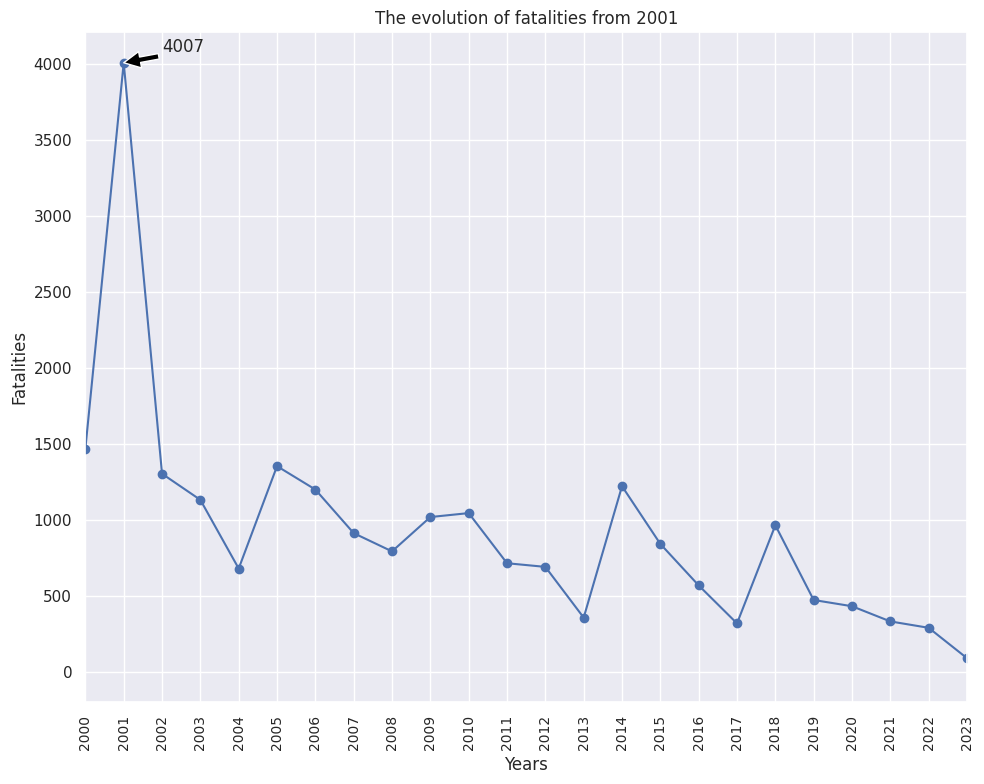

In [ ]:
#create a chart showing the trend of incidents from 2001 onwards.

plt.figure(figsize=(10,8))

plt.rcdefaults()

sns.set_theme()


plt.title("The evolution of fatalities from 2001")

plt.plot(grouped_df_copy_date["year"], grouped_df_copy_date["fatalities"], marker="o")

plt.xlabel("Years")

plt.ylabel("Fatalities")

plt.xticks(rotation=90, size=10)

plt.xlim("2000", "2023")

plt.annotate("4007", xy=("2001", 4007), xytext=("2002", 4080), arrowprops=dict(facecolor="black"))



plt.tight_layout()

plt.savefig("Fatalities Trend from 2001", dpi=300, bbox_inches="tight")

plt.show()

plt.close()

From the charts above, which show the trend in fatalities by year, with a particular focus on the trend from 2001 onward, we can see that the overall tendency over the last century has risen considerably since the 1930s. There have been many fluctuations, especially during the years of World War II and the Cold War, reaching a peak in 2001. Fortunately, in the following years, there has been a decline in fatalities due to aircraft incidents. Until 2019, the situation remained quite unstable, but in recent years, the numbers have fortunately been decreasing.

In [ ]:
#define a function which show fatalities information about the year passed as argument

def year_info(z):

  return grouped_df_copy_date.loc[grouped_df_copy_date["year"]==z]

#<font color="red"> Which aircraft caused the most deaths? </font>

In [ ]:
#group the DataFrame by aircraft and sum the number of deaths caused by each.

grouped_df_type= df_copy_date.groupby("type")["fatalities"].sum().reset_index()

In [ ]:
#sort the values

grouped_df_type=grouped_df_type.sort_values("type")

In [ ]:
#apply the encoding correction function

grouped_df_type["type"]=grouped_df_type["type"].apply(check_string)

Before plotting the DataFrame resulting from the grouping, I create two graphs: a violin plot and a box plot.
These plots represent the density of the data distribution using the median and position indices.
The data considered here are fatalities. What emerges from both graphs is a significantly higher density up to, approximately, 200 fatalities.
Therefore, I decide to focus the graphical representation on data above this threshold.

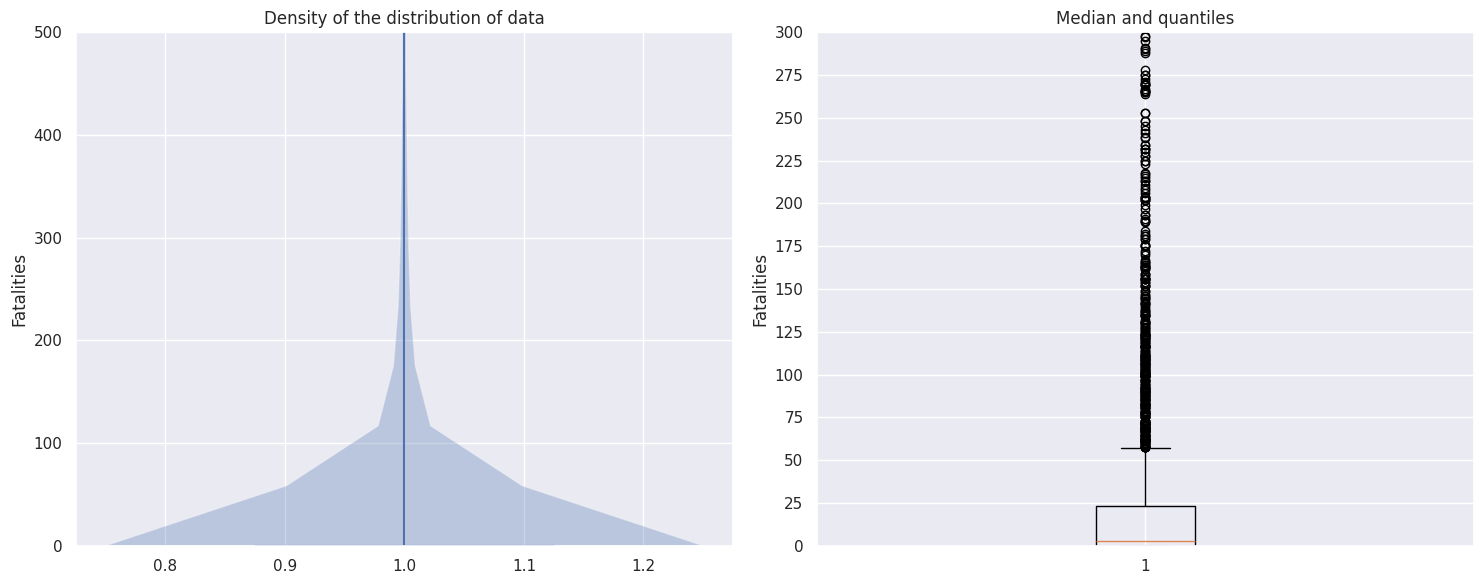

In [ ]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(15, 6))

plt.rcdefaults()

plt.rcParams["ytick.labelsize"]=7

sns.set_theme()



ax1.set_title("Density of the distribution of data")

ax1.violinplot([grouped_df_type["fatalities"]])

ax1.set_ylabel("Fatalities")

ax1.set_yticks(ticks=np.arange(0, 6050, 100))

ax1.set_ylim(0, 500)


ax2.set_title("Median and quantiles")

ax2.boxplot([grouped_df_type["fatalities"]])

ax2.set_ylabel("Fatalities")

ax2.set_yticks(ticks=np.arange(0, 6050, 25))

ax2.set_ylim(0, 300)


plt.tight_layout()

plt.show()

plt.close()

In [ ]:
#exclude values from 0 to 200 as explained above
#start by plotting vehicles that caused at least 1000 fatalities, in order to display the most dangerous aircrafts

_1000_to_over_3000=grouped_df_type.loc[(grouped_df_type["fatalities"]>=1000)|(grouped_df_type["fatalities"]>=3000)]

In [ ]:
#find the aircraft that caused the most deaths.

grouped_df_type.loc[grouped_df_type["fatalities"]==grouped_df_type["fatalities"].max()]

,type,fatalities
1710,Douglas C-47A (DC-3),5780.0


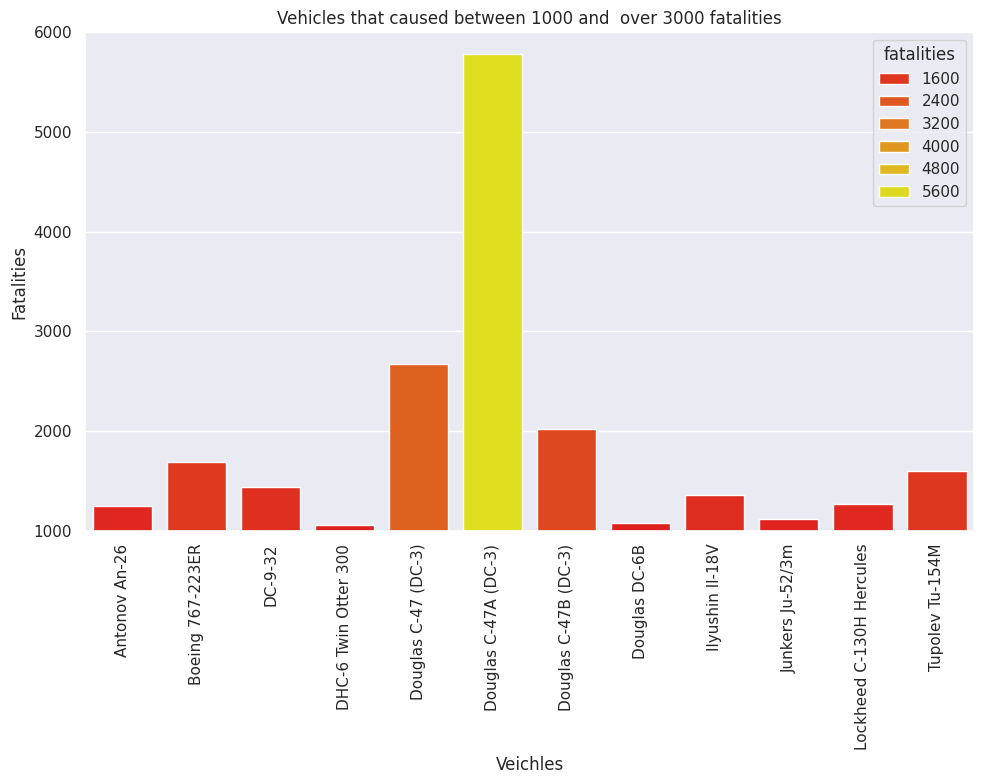

In [ ]:
#create a bar chart displaying the values from the DataFrame.

plt.figure(figsize=(10, 8))

plt.rcdefaults()

plt.rcParams["font.size"]=15

plt.rcParams["xtick.labelsize"]=10

sns.set_theme()


sns.barplot(x=_1000_to_over_3000["type"], y=_1000_to_over_3000["fatalities"], hue=_1000_to_over_3000["fatalities"], palette="autumn")

plt.title("Vehicles that caused between 1000 and  over 3000 fatalities")

plt.xlabel("Veichles")

plt.ylabel("Fatalities")

plt.xticks(rotation=90)

plt.ylim(1000.0, 6000.0)


plt.tight_layout()

plt.show()

plt.close()

In [ ]:
#define a function which show fatalities information about the aircraft passed as argument

def aircraft_info(t):

  return grouped_df_type.loc[grouped_df_type["type"]==t]

#<font color="red"> Which are the most dangerous operators? </font>

In [ ]:
#group the DataFrame by operators and display the number of fatalities for each

grouped_df_operator= df_copy_date.groupby("operator")["fatalities"].sum().reset_index()

In [ ]:
#apply the function which corretcs the incorrect encoding values

grouped_df_operator["operator"]= grouped_df_operator["operator"].apply(check_string)

Before plotting the DataFrame resulting from the grouping, I create two graphs: a violin plot and a box plot.
These plots represent the density of the data distribution using the median and position indices.
The data considered here are fatalities. What emerges from both graphs is a significantly higher density up to, approximately, 200 fatalities.
Therefore, I decide to focus the graphical representation on data above this threshold.

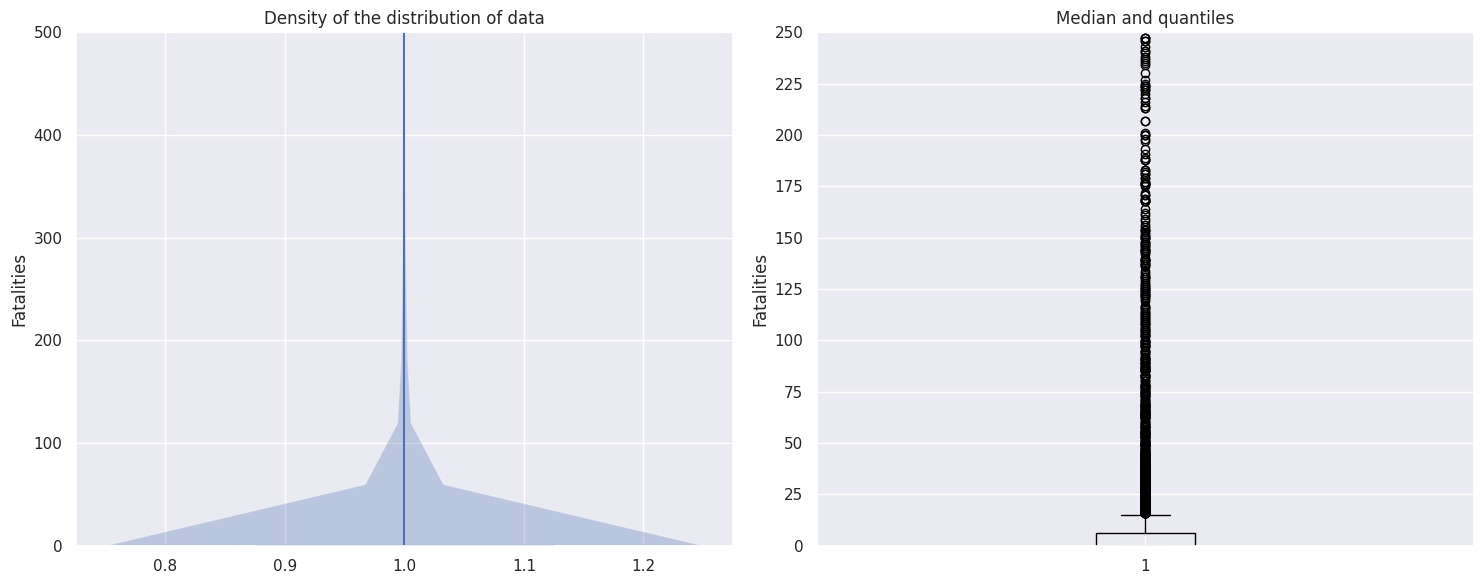

In [ ]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(15, 6))

plt.rcdefaults()

plt.rcParams["ytick.labelsize"]=7

sns.set_theme()



ax1.set_title("Density of the distribution of data")

ax1.violinplot([grouped_df_operator["fatalities"]])

ax1.set_ylabel("Fatalities")

ax1.set_yticks(ticks=np.arange(0, 6050, 100))

ax1.set_ylim(0, 500)


ax2.set_title("Median and quantiles")

ax2.boxplot([grouped_df_operator["fatalities"]])

ax2.set_ylabel("Fatalities")

ax2.set_yticks(ticks=np.arange(0, 6050, 25))

ax2.set_ylim(0, 250)


plt.tight_layout()

plt.show()

plt.close()

In [ ]:
#find the operator that caused the most deaths.

grouped_df_operator.loc[grouped_df_operator["fatalities"]==grouped_df_operator["fatalities"].max()]

,operator,fatalities
5607,USAF,5905.0


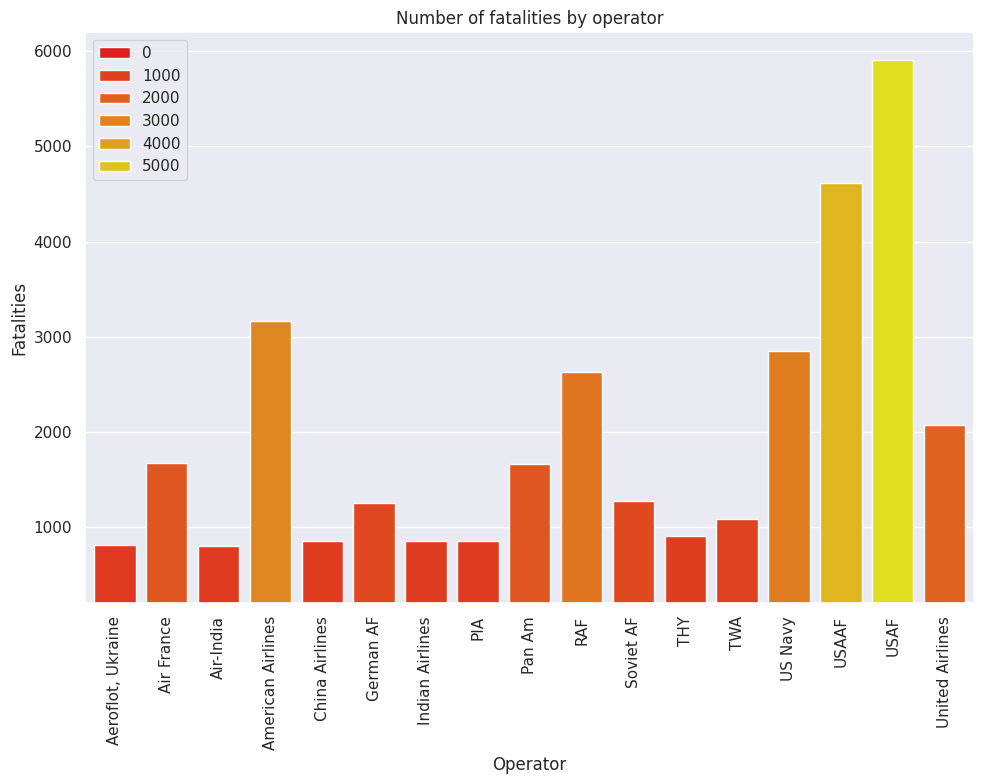

In [ ]:
#start by plotting operators that caused at least 800 fatalities, in order to display the most dangerous operators

plt.figure(figsize=(10, 8))

plt.rcdefaults()

plt.rcParams["font.size"]=10

sns.set_theme()


plt.title("Number of fatalities by operator")

sns.barplot (x=grouped_df_operator.query("fatalities >800")["operator"], y=grouped_df_operator.query("fatalities >800")["fatalities"]

             , hue=grouped_df_operator["fatalities"], palette="autumn", legend="brief")

plt.margins(x=0.01)

plt.xlabel("Operator")

plt.ylabel("Fatalities")

plt.xticks(rotation=90)

plt.ylim(200)

plt.legend(loc="upper left")


plt.tight_layout()

plt.show()

plt.close()

In [ ]:
#define a function which show fatalities information about the operator passed as argument

def operator_info(o):

  return grouped_df_operator.loc[grouped_df_operator["operator"]==o]

#<font color="red"> The most dangerous location </font>

In [ ]:
#make a copy of the original DataFrame

df_copy_loc= df.copy()

In [ ]:
#clear the fatalities column

df_copy_loc["fatalities"]= df_copy_loc["fatalities"].apply(data_cleaner)

In [ ]:
#remove NaN values from the DataFrame because if the location of the incident is unknown,
#it's not relevant to know whether there were fatalities in that row. These could be related to the country,
#but since this is an analysis of incident locations, knowing only that a certain number of deaths occurred in a country is insufficient.
#That analysis is covered above.


grouped_df_loc= df_copy_loc.groupby(df_copy_loc["location"].dropna())["fatalities"].sum().reset_index()

In [ ]:
#apply the function on the location column

grouped_df_loc["location"]=grouped_df_loc["location"].apply(check_string)

Before plotting the DataFrame resulting from the grouping, I create two graphs: a violin plot and a box plot.
These plots represent the density of the data distribution using the median and position indices.
The data considered here are fatalities. What emerges from both graphs is a significantly higher density up to, approximately, 150 fatalities.
Therefore, I decide to focus the graphical representation on data above this threshold.

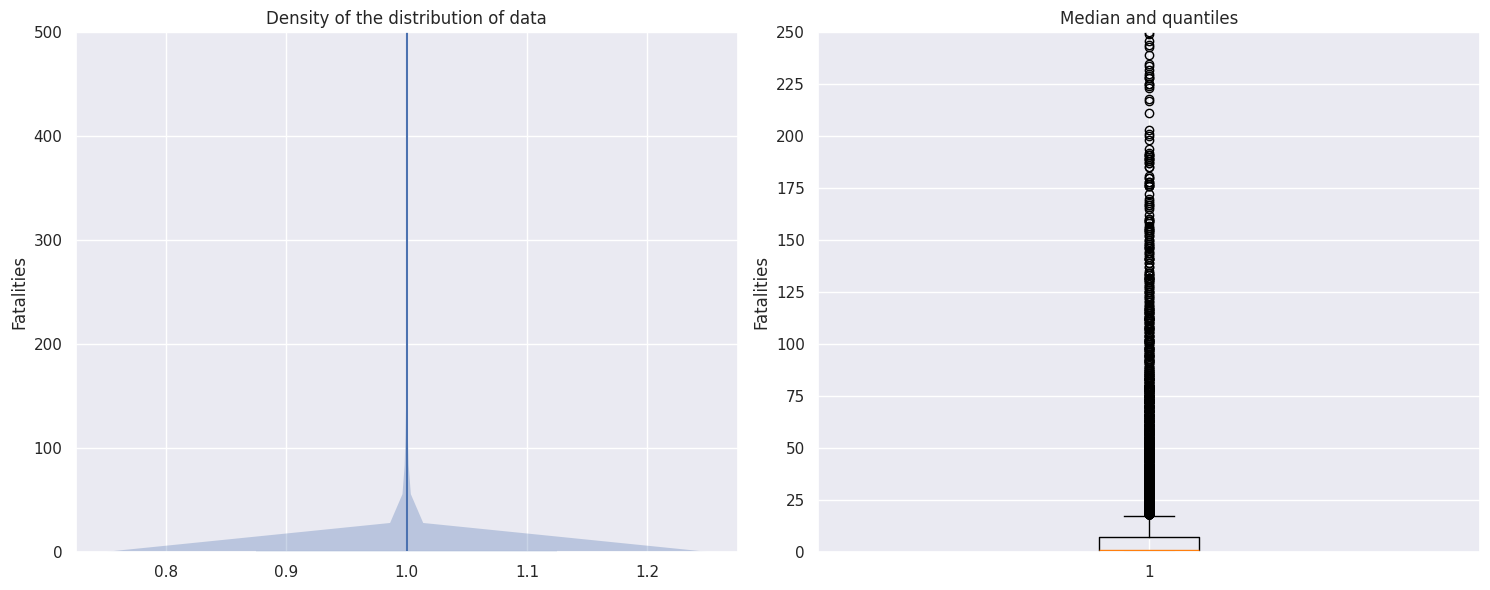

In [ ]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(15, 6))

plt.rcdefaults()

plt.rcParams["ytick.labelsize"]=7


ax1.set_title("Density of the distribution of data")

ax1.violinplot([grouped_df_loc["fatalities"]])

ax1.set_ylabel("Fatalities")

ax1.set_yticks(ticks=np.arange(0, 6050, 100))

ax1.set_ylim(0, 500)


ax2.set_title("Median and quantiles")

ax2.boxplot([grouped_df_loc["fatalities"]])

ax2.set_ylabel("Fatalities")

ax2.set_yticks(ticks=np.arange(0, 6050, 25))

ax2.set_ylim(0, 250)


plt.tight_layout()

plt.show()

plt.close()

In [ ]:
#find the location that caused the most deaths.

grouped_df_loc.loc[grouped_df_loc["fatalities"]==grouped_df_loc["fatalities"].max()]

,location,fatalities
5212,"New York, NY",2747.0


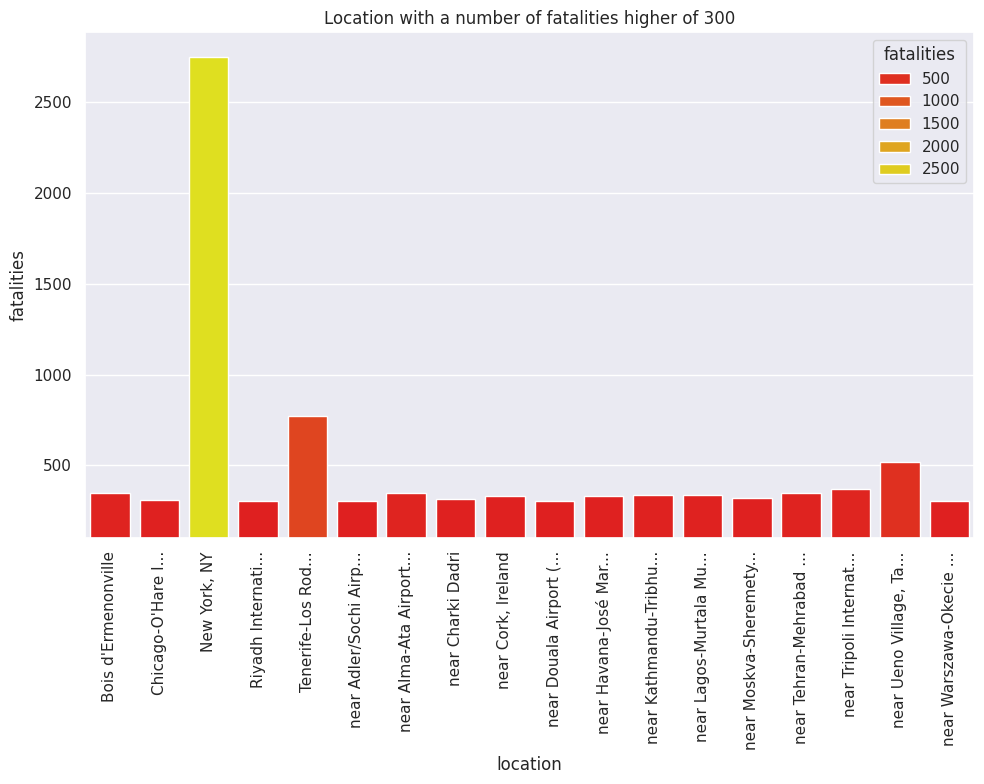

In [ ]:
#start by plotting locations in which there had been at least 300 fatalities, in order to display the most dangerous locations

plt.figure(figsize=(10, 8))

plt.rcdefaults()

plt.rcParams["font.size"]=10

plt.rcParams["xtick.labelsize"]=6

sns.set_theme()


sns.barplot(x=grouped_df_loc.query("fatalities >300")["location"], y=grouped_df_loc.query("fatalities >300")["fatalities"], hue=grouped_df_loc.query("fatalities >300")["fatalities"], palette="autumn")

plt.title("Location with a number of fatalities higher of 300")

plt.xticks(rotation=90)

plt.ylim(100)



plt.tight_layout()

plt.show()

plt.close()

In [ ]:
#define a function which show fatalities information about the location passed as argument

def location_info(l):

  return grouped_df_loc.loc[grouped_df_loc["location"]==l]